### Multidimensional Scaling (MDS)
***
***

Set working directory and load the LDND distance matrix, as it had the best score when considering the whole language tree.

In [1]:
setwd("C:/Users/stein/Dropbox/Studium/7. Semester/BA-Thesis/BA-Thesis_NorthEuraLex")

ldnd_dists = read.csv("./language_distances/ldnd_dists.csv")

***
Load _smacof_ library and test different MDS methods on the LDND matrix, with three dimensions.

In [2]:
library(smacof)
fit.ldnd_ratio = mds(ldnd_dists, ndim = 3, type = "ratio")
fit.ldnd_interval = mds(ldnd_dists, ndim = 3, type = "interval")
fit.ldnd_mspline = mds(ldnd_dists, ndim = 3, type = "mspline")
fit.ldnd_ratio
fit.ldnd_interval
fit.ldnd_mspline

Lade nötiges Paket: plotrix

Lade nötiges Paket: colorspace

Lade nötiges Paket: e1071


Attache Paket: 'smacof'


Das folgende Objekt ist maskiert 'package:base':

    transform





Call:
mds(delta = ldnd_dists, ndim = 3, type = "ratio")

Model: Symmetric SMACOF 
Number of objects: 107 
Stress-1 value: 0.29 
Number of iterations: 322 



Call:
mds(delta = ldnd_dists, ndim = 3, type = "interval")

Model: Symmetric SMACOF 
Number of objects: 107 
Stress-1 value: 0.269 
Number of iterations: 44 



Call:
mds(delta = ldnd_dists, ndim = 3, type = "mspline")

Model: Symmetric SMACOF 
Number of objects: 107 
Stress-1 value: 0.254 
Number of iterations: 219 


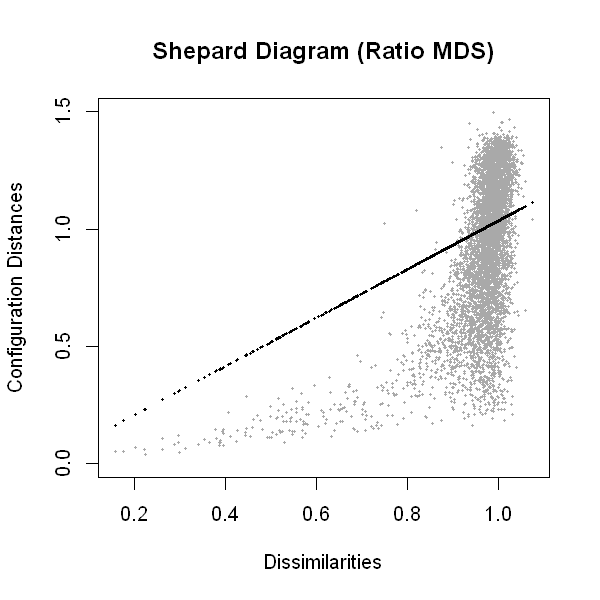

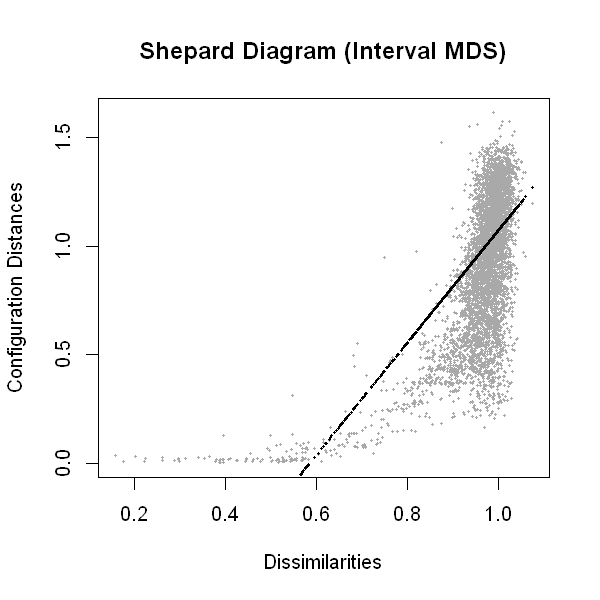

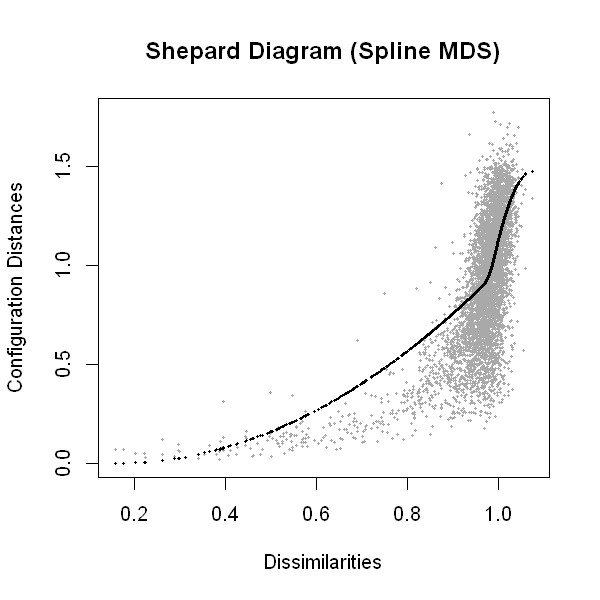

In [3]:
options(repr.plot.width=5, repr.plot.height=5)
plot(fit.ldnd_ratio, plot.type = "Shepard",
main = "Shepard Diagram (Ratio MDS)")
plot(fit.ldnd_interval, plot.type = "Shepard",
main = "Shepard Diagram (Interval MDS)")
plot(fit.ldnd_mspline, plot.type = "Shepard",
main = "Shepard Diagram (Spline MDS)")

As visible from the Shepard Diagrams, the MDS fit with _mspline_ transformation best captures the structure of the data.
***
The _mspline_ can be slightly modifed by changing the _spline.degree_ from the default value of 2 to 5, improving the fit and lowering the stress further. To avoid overfitting the parameters are not changed further.

[1] "Stress"


[1] 0.2416913

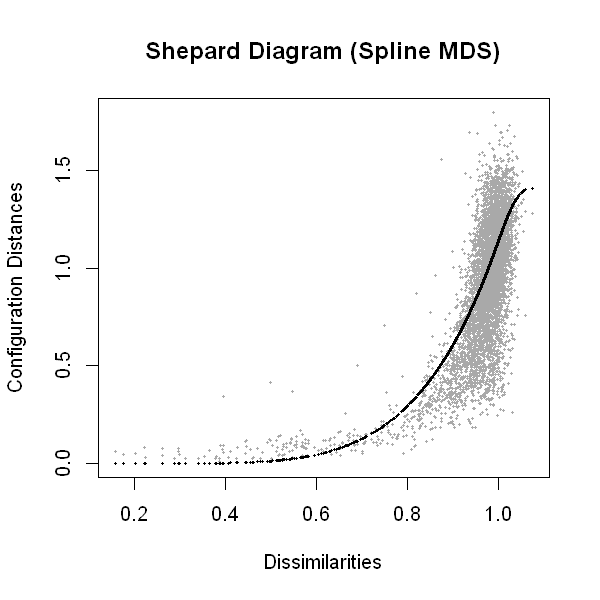

In [4]:
fit.ldnd = mds(ldnd_dists, ndim = 3, type = "mspline", spline.degree = 5, spline.intKnots = 2)
print("Stress")
fit.ldnd$stress
plot(fit.ldnd, plot.type = "Shepard",
main = "Shepard Diagram (Spline MDS)")

***
Going by thumb rules, the stress of the MDS is too high. To make sure it is a good fit, a permutation test is applied (1000 iterations, thus takes a while).


Call: permtest.smacof(object = fit.ldnd, nrep = 1000, verbose = FALSE)

SMACOF Permutation Test
Number of objects: 107 
Number of replications (permutations): 1000 

Observed stress value: 0.242 
p-value: <0.001 


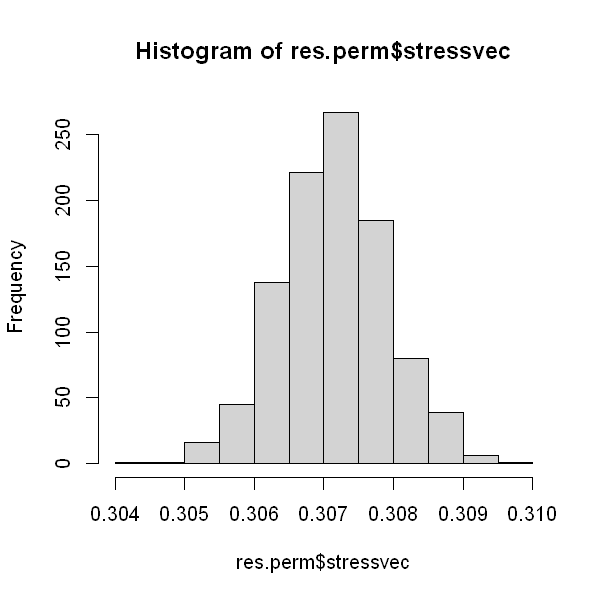

In [5]:
res.perm <- permtest(fit.ldnd, nrep = 1000, verbose = FALSE)
res.perm
hist(res.perm$stressvec)

The p-value is smaller than 0.001, as the stress values of the permutations are all significantly higher then the stress calculated on the original matrix (0.245), thus confirming that the MDS fits the data.
***
#### Visualization
***
Load tidyverse again to read in the NorthEuraLex language data.

In [6]:
library(tidyverse)

geodata = read_tsv("./data/northeuralex-0.9-language-data.tsv", show_col_types = FALSE)
head(geodata)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


name,glotto_code,iso_code,family,subfamily,latitude,longitude
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Finnish,finn1318,fin,Uralic,Finnic,61.0000,24.4500
North Karelian,kare1335,krl,Uralic,Finnic,65.1691,30.8655
Olonets Karelian,livv1243,olo,Uralic,Finnic,61.0000,33.0000
Veps,veps1250,vep,Uralic,Finnic,60.3353,34.7865
Estonian,esto1258,ekk,Uralic,Finnic,59.2500,24.7500
Livonian,livv1244,liv,Uralic,Finnic,57.5660,22.0262


***
Convert the 3 coordinates from the MDS to a color for each language. Afterwards, join the tibble containing the color information with the language data tibble and convert the coordinates from NorthEuraLex to simple features, so the _sf_ can work with them. This will be done many more times, and is therefore written as a function.

In [7]:
library(sf)

colour_and_convert = function(fit.mds, range_a, range_b = range_a) {

   mds_data = 
        fit.mds$conf[range_a,] %>%
        # convert matrix containing the coordinates to tibble
        as_tibble() %>%
        # add column with ISO codes
        mutate(iso_code = slice(geodata, range_b)$iso_code) %>%
        # subtract the smallest value (Step 1/2)
        mutate(x = D1 - min(.$D1), y = D2 - min(.$D2), z = D3 - min(.$D3)) %>%
        # divide by maximum value (Step 2/2, all values are between 0 and 1 now))
        mutate(r = x / max(.$x), g = y / max(.$y), b = z / max(.$z)) %>%
        # combine r, g, and b into a color
        mutate(col = rgb(r,g,b)) %>%
        # select the only two relevant columns
        select(iso_code, col, r, g, b)

    coloured_mds = 
        slice(geodata, range_b) %>% 
        select(iso_code, latitude, longitude, name, family, subfamily) %>%
        inner_join(mds_data) %>%
        st_as_sf(coords=c("longitude", "latitude"), crs=4326) %>%
        st_transform("+proj=eqearth lon_0=125")
    
}


coloured_northeuralex = colour_and_convert(fit.ldnd, 1:107)

Linking to GEOS 3.9.3, GDAL 3.5.2, PROJ 8.2.1; sf_use_s2() is TRUE

Joining, by = "iso_code"


***
Move the central meridian to 125° E.

In [8]:
# produce an extremely slim polygon that represents the 60° W meridian
meridian_55_west = 
  st_polygon(x = list(rbind(c(-55.0001, 90), # upper left corner of the polygon
                            c(-55, 90), # upper right corner of the polygon
                            c(-55, -90), # lower right corner of the polygon
                            c(-55.0001, -90), # lower left corner of the polygon
                            c(-55.0001, 90)))) %>%
  st_sfc() %>%
  # set the crs of the polygon to the geodetic system for world
  st_set_crs(4326)

library(spData)

# remove everything on the 60° meridian from the world data, effectively cutting all polygons that cross the meridian
world_without_55 = 
  world %>% 
  st_difference(meridian_55_west) %>% 
  st_transform("+proj=eqearth lon_0=125")

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


***
Plot the languages on the projected map. Code that is commented out saves the resulting map instead of showing it in the plot window. As many differents plots are needed, this is also written as a function. 

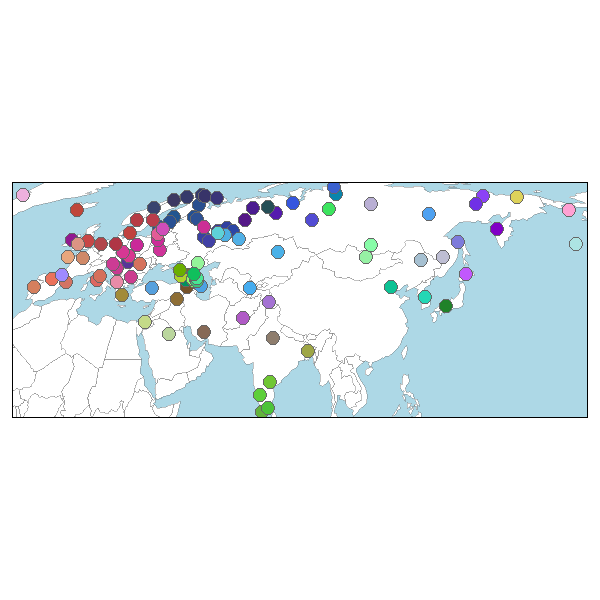

In [9]:
library(tmap)

# tmap_save(
coloured_northeuralex %>%
        tm_shape() +
        tm_symbols(size=0.2) +
        tm_shape(world_without_55) +
        tm_polygons(alpha = 1, col = 'white', border.alpha = 0.4) +
        tm_layout(bg.color = 'lightblue') +
        tm_shape(coloured_northeuralex) +
        tm_symbols(size=0.6, col="col", border.lwd=1, alpha=1)
# ,filename="./imgs/ldnd_northeuralex.png" , dpi = 600)

This block creates the map of the Uralic language family.

Joining, by = "iso_code"


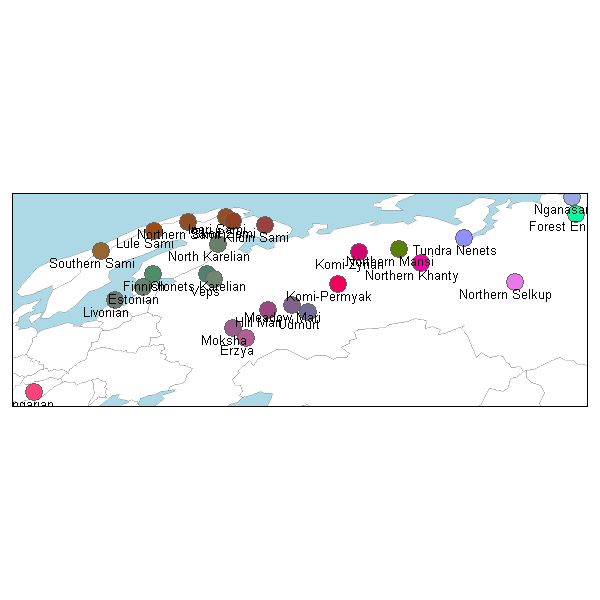

In [10]:
coloured_uralic = colour_and_convert(fit.ldnd, 1:26)
 
bbox_uralic = st_bbox(coloured_uralic)
xrange = bbox_uralic$xmax - bbox_uralic$xmin
yrange = bbox_uralic$ymax - bbox_uralic$ymin

bbox_uralic[1] <- bbox_uralic[1] - (0.02 * xrange)
bbox_uralic[2] <- bbox_uralic[2] - (0.05 * yrange)

# tmap_save(
coloured_uralic %>%
    tm_shape(bbox = bbox_uralic) +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = 'white', border.alpha = 0.3) +
    tm_layout(bg.color = 'lightblue') +
    tm_shape(coloured_uralic) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1) +
    tm_text('name', size = 2/3, just = 'top', fontface = "bold", fontfamily = "sans", xmod = -0.5,ymod = -0.5)
# , filename="./imgs/uralic_ldnd.png" ,dpi = 600)

***
Calculate the number of pairwise distance in the matrix, that are higher than 0.95. Afterward, get the max distance in the Basque row, and the minimum distance that is higher than 0.95.

In [11]:
sum(ldnd_dists > 0.95) / (107 * 106)
sort(ldnd_dists[96,], T)[1]
sort(ldnd_dists[96,], F)[6]

[1] 0.7862811

Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"


,V52
,<dbl>
96,1.036803


Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"


,V83
,<dbl>
96,0.950054


Create a new Uralic map with the PMI-based distance matrix (permtest takes a while, because of 1000 iterations).

[1] "Stress"


[1] 0.2181217


Call: permtest.smacof(object = fit.pmi, nrep = 1000, verbose = FALSE)

SMACOF Permutation Test
Number of objects: 107 
Number of replications (permutations): 1000 

Observed stress value: 0.218 
p-value: <0.001 


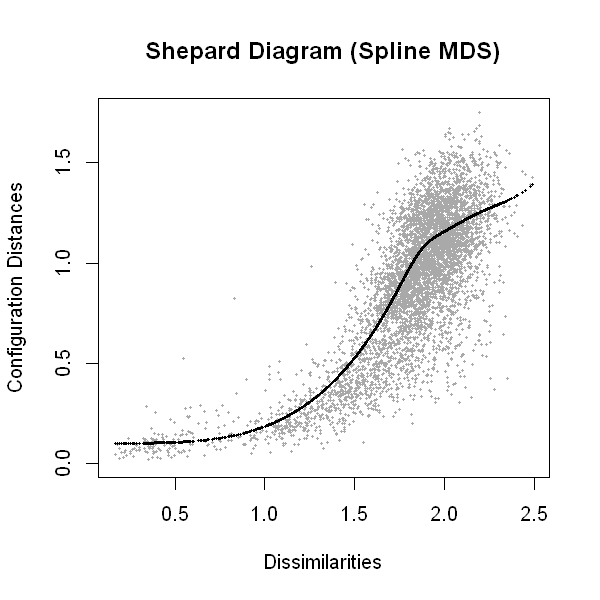

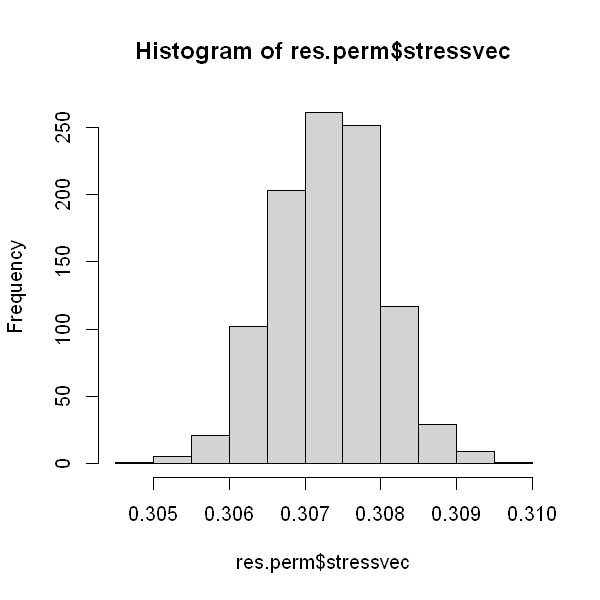

In [12]:
pmi_dists = read.csv("./language_distances/pmi_dists.csv")

fit.pmi = mds(pmi_dists, ndim = 3, type = "mspline", spline.degree = 4, spline.intKnots = 4)

print("Stress")
fit.pmi$stress
plot(fit.pmi, plot.type = "Shepard", main = "Shepard Diagram (Spline MDS)")

res.perm <- permtest(fit.pmi, nrep = 1000, verbose = FALSE)
res.perm
hist(res.perm$stressvec)

Joining, by = "iso_code"


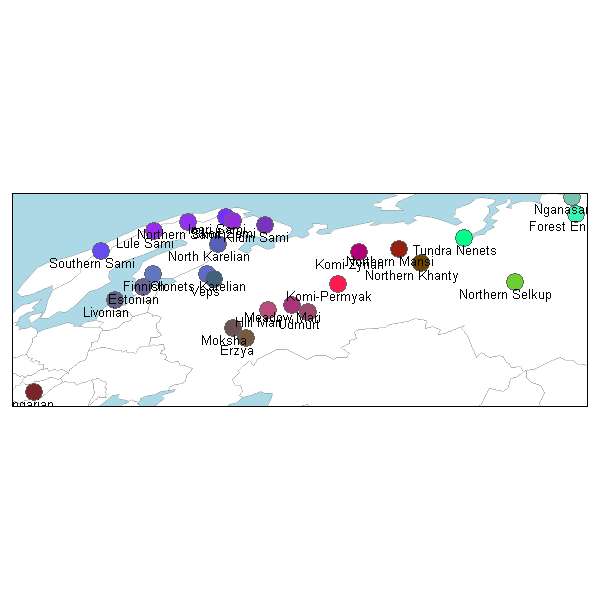

In [13]:
coloured_uralic_pmi = colour_and_convert(fit.pmi, 1:26)

# tmap_save(
coloured_uralic_pmi %>%
    tm_shape(bbox = bbox_uralic) +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = 'white', border.alpha = 0.3) +
    tm_layout(bg.color = 'lightblue') +
    tm_shape(coloured_uralic_pmi) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1) +
    tm_text('name', size = 2/3, just = 'top', fontface = "bold", fontfamily = "sans", xmod = -0.5,ymod = -0.5)
# ,filename="./imgs/uralic_pmi.png" ,dpi = 600)

***
Map the Indo-European languages.

Joining, by = "iso_code"


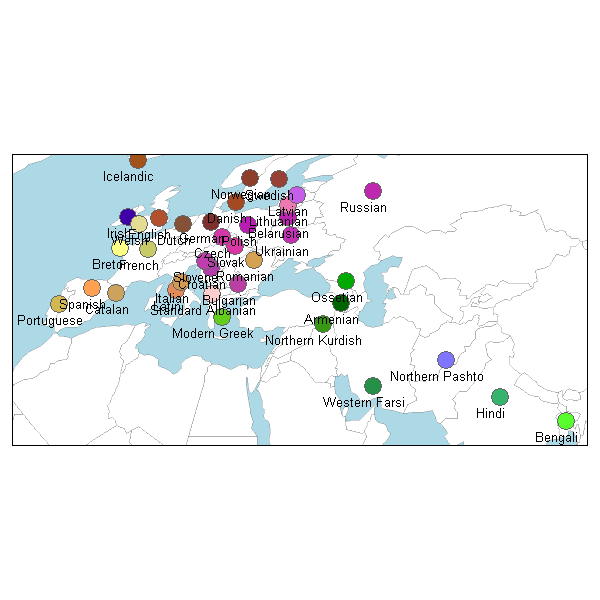

In [14]:
coloured_indo_ldnd = colour_and_convert(fit.ldnd, 27:63)

bbox_indo = st_bbox(coloured_indo_ldnd)
xrange = bbox_indo$xmax - bbox_indo$xmin
yrange = bbox_indo$ymax - bbox_indo$ymin

bbox_indo[1] <- bbox_indo[1] - (0.07 * xrange)
bbox_indo[3] <- bbox_indo[3] + (0.02 * xrange)
bbox_indo[2] <- bbox_indo[2] - (0.07 * yrange)

# shorten label so it does not collide with label for Swedish
coloured_indo_ldnd$name[22] = "Norwegian"

# tmap_save(
coloured_indo_ldnd %>%
    tm_shape(bbox = bbox_indo) +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = 'white', border.alpha = 0.3) +
    tm_layout(bg.color = 'lightblue') +
    tm_shape(coloured_indo_ldnd) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1) +
    tm_text('name', size = 2/3, just = 'top', fontface = "bold", fontfamily = "sans", xmod = -0.5,ymod = -0.5)
# , filename="./imgs/indo_ldnd.png" ,dpi = 600)

Joining, by = "iso_code"


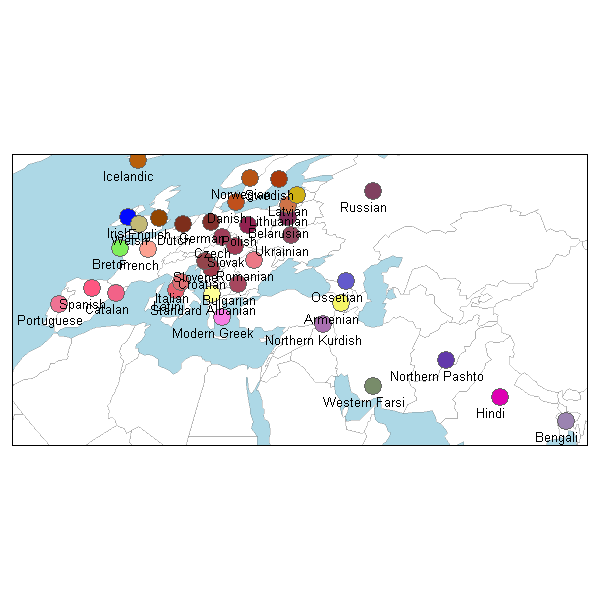

In [15]:
coloured_indo_pmi = colour_and_convert(fit.pmi, 27:63)

# shorten label so it does not collide with Swpmi_dists = read.csv("./language_distances/pmi_dists.csv")
coloured_indo_pmi$name[22] = "Norwegian"

#tmap_save(
coloured_indo_pmi %>%
    tm_shape(bbox = bbox_indo) +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = 'white', border.alpha = 0.3) +
    tm_layout(bg.color = 'lightblue') +
    tm_shape(coloured_indo_pmi) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1) +
    tm_text('name', size = 2/3, just = 'top', fontface = "bold", fontfamily = "sans", xmod = -0.5,ymod = -0.5)
#, filename="./imgs/indo_pmi.png" ,dpi = 600)

***
Fit MDS on PMI-based matrix without potential rogue taxa.

In [16]:
rogue_taxa = c("abk", "ady", "eus", "bsk", "kat", "kca", "kor", "mns", "yrk", "sel", "ykg")
rogue_inds = which(!(geodata$iso_code %in% rogue_taxa))

pmi_dists_rogue = pmi_dists[rogue_inds, rogue_inds]
# already prepare for LDND without rogue taxa as well
ldnd_dists_rogue = ldnd_dists[rogue_inds, rogue_inds]

[1] "Stress"


[1] 0.209444


Call: permtest.smacof(object = fit.pmi_rogue, nrep = 100, verbose = FALSE)

SMACOF Permutation Test
Number of objects: 96 
Number of replications (permutations): 100 

Observed stress value: 0.209 
p-value: <0.001 


Joining, by = "iso_code"


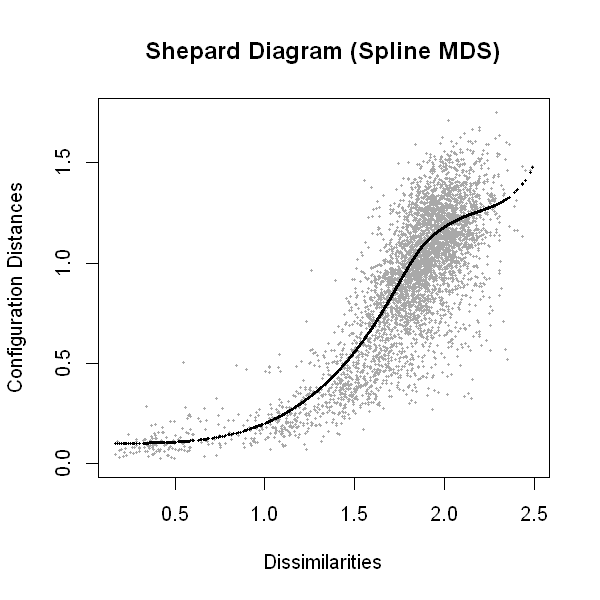

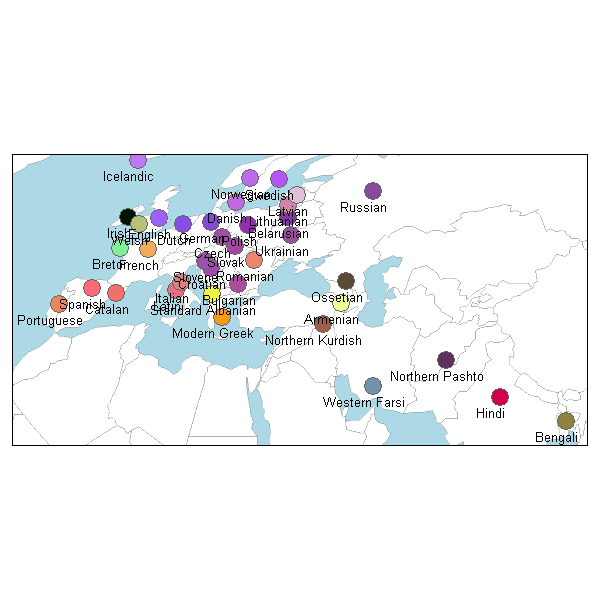

In [17]:
fit.pmi_rogue = mds(pmi_dists_rogue, ndim = 3, type = "mspline", spline.degree = 4, spline.intKnots = 4)

print("Stress")
fit.pmi_rogue$stress
plot(fit.pmi_rogue, plot.type = "Shepard", main = "Shepard Diagram (Spline MDS)")

res.perm <- permtest(fit.pmi_rogue, nrep = 100, verbose = FALSE)
res.perm

coloured_indo_pmi_rogue = colour_and_convert(fit.pmi_rogue, 23:59, 27:63)

# shorten label so it does not collide with label for Swedish
coloured_indo_pmi_rogue$name[22] = "Norwegian"

# tmap_save(
coloured_indo_pmi_rogue %>%
    tm_shape(bbox = bbox_indo) +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = "white", border.alpha = 0.3) +
    tm_layout(bg.color = "lightblue") +
    tm_shape(coloured_indo_pmi_rogue) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1) +
    tm_text("name", size = 2/3, just = "top", fontface = "bold", fontfamily = "sans", xmod = -0.5,ymod = -0.5)
#         , filename="./imgs/indo_pmi_rogue.png" ,dpi = 600)

***
Fit MDS on LDND matrix without potential rogue taxa.

[1] "Stress"


[1] 0.2311121


Call: permtest.smacof(object = fit.ldnd_rogue, nrep = 100, verbose = FALSE)

SMACOF Permutation Test
Number of objects: 96 
Number of replications (permutations): 100 

Observed stress value: 0.231 
p-value: <0.001 


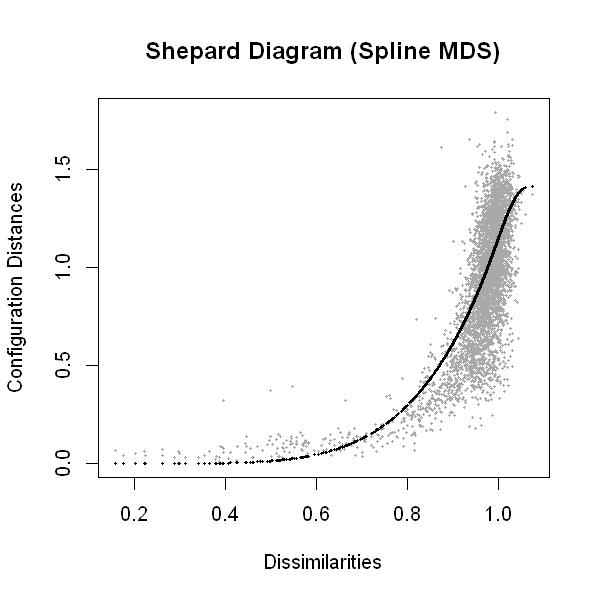

In [18]:
fit.ldnd_rogue = mds(ldnd_dists_rogue, ndim = 3, type = "mspline", spline.degree = 5, spline.intKnots = 2)

print("Stress")
fit.ldnd_rogue$stress
plot(fit.ldnd_rogue, plot.type = "Shepard", main = "Shepard Diagram (Spline MDS)")

res.perm <- permtest(fit.ldnd_rogue, nrep = 100, verbose = FALSE)
res.perm

Joining, by = "iso_code"


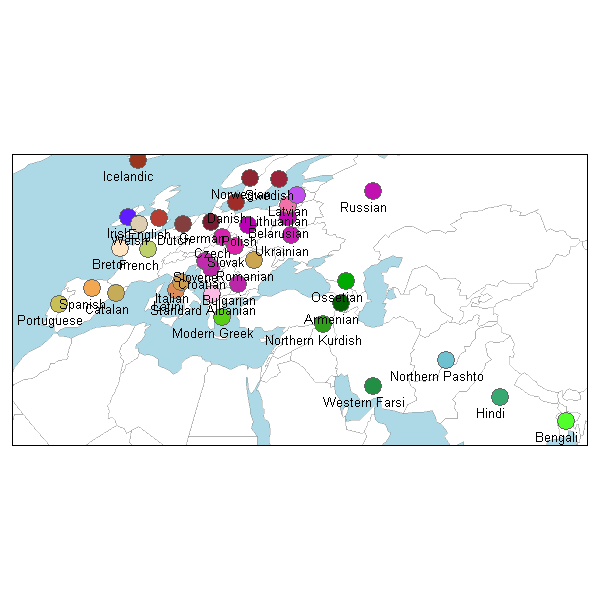

In [19]:
coloured_indo_ldnd_rogue = colour_and_convert(fit.ldnd_rogue, 23:59, 27:63)

# shorten label so it does not collide with label for Swedish
coloured_indo_ldnd_rogue$name[22] = "Norwegian"

# tmap_save(
coloured_indo_ldnd_rogue %>%
    tm_shape(bbox = bbox_indo) +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = "white", border.alpha = 0.3) +
    tm_layout(bg.color = "lightblue") +
    tm_shape(coloured_indo_ldnd_rogue) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1) +
    tm_text("name", size = 2/3, just = "top", fontface = "bold", fontfamily = "sans", xmod = -0.5,ymod = -0.5)
# ,filename="./imgs/indo_ldnd_rogue.png" ,dpi = 600)